# LIBRARY

In [1]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00


In [2]:
import numpy as np
from numpy import newaxis
import pandas as pd
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# Preprocessing

In [3]:
def plot_results(historical_data,predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    historical_data = scaler.inverse_transform(historical_data.reshape(-1, 1))
    predicted_data = scaler.inverse_transform(predicted_data.reshape(-1, 1))
    true_data = scaler.inverse_transform(true_data.reshape(-1, 1))
    # Define the length of the historical data
    len_historical = len(historical_data)

    # Create arrays for plotting that offset the true and predicted data
    offset_true_data = np.empty(len_historical + len(true_data))
    offset_true_data[:] = np.nan
    offset_true_data[len_historical:] = true_data.squeeze()

    offset_predicted_data = np.empty(len_historical + len(predicted_data))
    offset_predicted_data[:] = np.nan
    offset_predicted_data[len_historical:] = predicted_data.squeeze()

    # Plot the data
    ax.plot(historical_data, label='Historical Data')
    ax.plot(offset_true_data, label='True Data')
    ax.plot(offset_predicted_data, label='Predicted Data')

    plt.legend()
    plt.show()

In [4]:
# Load datasets
train_df = pd.read_csv('/content/drive/MyDrive/Time Series/Project Final/Data/MWG Historical Data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Time Series/Project Final/Data/MWG Historical Data Test.csv')

In [5]:
train_df

,Date,Price,Open,High,Low,Vol.,Change %
0,02/28/2022,"67,560","67,809","68,554","67,312",3.60M,-1.16%
1,02/25/2022,"68,355","68,008","69,448","67,560",5.38M,0.58%
2,02/24/2022,"67,958","68,057","68,405","67,312",2.35M,-0.73%
3,02/23/2022,"68,455","68,405","69,846","68,008",3.22M,0.07%
4,02/22/2022,"68,405","66,070","69,150","65,772",6.55M,2.84%
...,...,...,...,...,...,...,...
1030,01/08/2018,"31,110","31,394","31,513","31,039",3.01M,-1.58%
1031,01/05/2018,"31,608","31,987","31,987","31,465",2.93M,-1.11%
1032,01/04/2018,"31,963","31,773","32,081","31,750",2.71M,0.22%
1033,01/03/2018,"31,892","31,323","32,034","31,276",4.53M,1.97%


In [6]:
import pandas as pd

# Convert 'Date' column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Sort the dataframes by 'Date' and reset the index
train_df = train_df.sort_values('Date').reset_index(drop=True)
test_df = test_df.sort_values('Date').reset_index(drop=True)

# Set the 'Date' column as the index
train_df = train_df.set_index('Date')
test_df = test_df.set_index('Date')

# Resample the dataframes to daily frequency and forward-fill missing values
train_df = train_df.asfreq('D').fillna(method="ffill")
test_df = test_df.asfreq('D').fillna(method="ffill")


In [7]:
# Convert specified columns to float
columns_to_convert = ['Price', 'Open', 'High', 'Low']
for column in columns_to_convert:
    train_df[column] = train_df[column].str.replace(',', '').astype(float)
    test_df[column] = test_df[column].str.replace(',', '').astype(float)
# Select the feature to predict, e.g., 'Price'
feature = 'Price'

In [8]:
# Normalize the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df[[feature]])
test_data = scaler.transform(test_df[[feature]])

In [9]:
# Prepare the data for LSTM/GRU
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



In [10]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# FINE_TUNING

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=10, min_lr=0.001)

In [12]:
def build_model_LSTM(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.05, max_value=0.5, step=0.05)))
    model.add(LSTM(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)))
    model.add(Dense(units=1,activation = "linear"))

    model.compile(optimizer=optimizers.AdamW(learning_rate=hp.Choice('learning_rate', values=[0.005, 0.001, 0.002])),
                  loss='mean_squared_error')

    return model

tuner = kt.RandomSearch(build_model_LSTM,
                        objective='val_loss',
                        max_trials=15,
                        executions_per_trial=1,
                        directory='tuning_dir_LSTM',
                        project_name='stock_price_prediction')

tuner.search(X_train, y_train, batch_size=16, epochs=30, validation_split= 0.25,callbacks=[early_stopping, reduce_lr], verbose=1)


Trial 15 Complete [00h 01m 48s]
val_loss: 0.00035390452831052244

Best val_loss So Far: 0.00027618458261713386
Total elapsed time: 00h 25m 49s


In [13]:
best_hps = tuner.get_best_hyperparameters()[0].values # Get the best hyperparameter configuration

# Print the optimal values
print("Optimal hyperparameters:")
for key, value in best_hps.items():
    print(f"{key}: {value}")

Optimal hyperparameters:
units: 105
dropout_rate: 0.1
learning_rate: 0.002


In [15]:
best_model_LSTM = tuner.get_best_models(num_models=1)[0]

In [16]:
best_model_LSTM.save("/content/drive/MyDrive/Time Series/Project Final/Code/LSTM_MWG.keras")

13/13 [==============================] - 1s 8ms/step


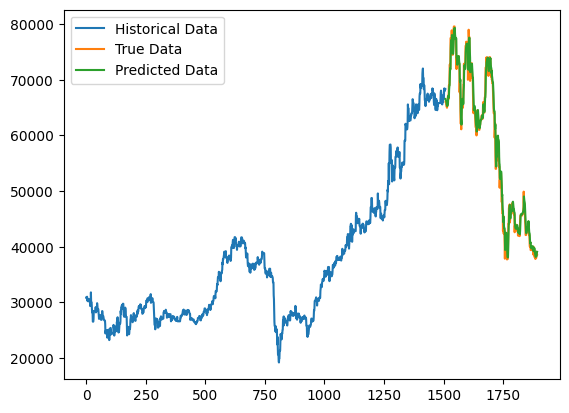

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 105)           44940     
                                                                 
 dropout (Dropout)           (None, 10, 105)           0         
                                                                 
 lstm_1 (LSTM)               (None, 105)               88620     
                                                                 
 dropout_1 (Dropout)         (None, 105)               0         
                                                                 
 dense (Dense)               (None, 1)                 106       
                                                                 
Total params: 133666 (522.13 KB)
Trainable params: 133666 (522.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
predicted_stock_price = best_model_LSTM.predict(X_test)
plot_results(y_train,predicted_stock_price,y_test)
best_model_LSTM.summary()

In [18]:
def build_model_GRU(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.05, max_value=0.5, step=0.05)))
    model.add(GRU(units=hp.Int('units', min_value=5, max_value=300, step=5), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05)))
    model.add(Dense(units=1,activation = "linear"))

    model.compile(optimizer=optimizers.AdamW(learning_rate=hp.Choice('learning_rate', values=[0.005, 0.001, 0.002])),
                  loss='mean_squared_error')

    return model

tuner1 = kt.RandomSearch(build_model_GRU,
                        objective='val_loss',
                        max_trials=15 ,
                        executions_per_trial=1,
                        directory='tuning_dir',
                        project_name='stock_price_prediction')

tuner1.search(X_train, y_train, batch_size=16, epochs=30, validation_split = 0.25,callbacks=[early_stopping, reduce_lr], verbose=1)

best_model1 = tuner1.get_best_models(num_models=1)[0]

Trial 15 Complete [00h 00m 42s]
val_loss: 0.00030014090589247644

Best val_loss So Far: 0.00030014090589247644
Total elapsed time: 00h 12m 00s


In [19]:
best_model1.save('/content/drive/MyDrive/Time Series/Project Final/Code/GRU_MWG.keras')

In [20]:
best_hps_GRU = tuner1.get_best_hyperparameters()[0].values # Get the best hyperparameter configuration

# Print the optimal values
print("Optimal hyperparameters:")
for key, value in best_hps_GRU.items():
    print(f"{key}: {value}")

Optimal hyperparameters:
units: 125
dropout_rate: 0.05
learning_rate: 0.002


13/13 [==============================] - 1s 9ms/step


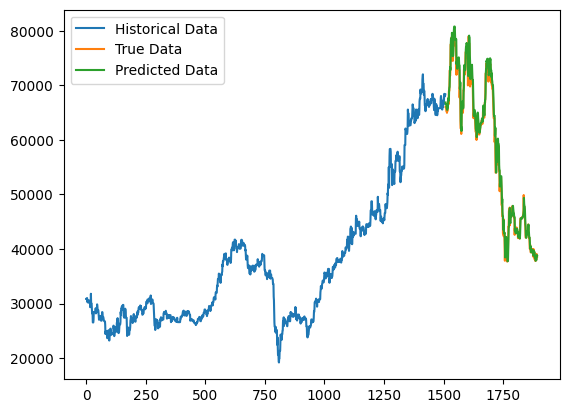

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 125)           48000     
                                                                 
 dropout (Dropout)           (None, 10, 125)           0         
                                                                 
 gru_1 (GRU)                 (None, 125)               94500     
                                                                 
 dropout_1 (Dropout)         (None, 125)               0         
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 142626 (557.13 KB)
Trainable params: 142626 (557.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#Let's use the model and predict the stock
gru_predictions = best_model1.predict(X_test)
plot_results(y_train,gru_predictions,y_test)
best_model1.summary()

# Evaluation

In [22]:
predicted_stock_price_rescale= scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
gru_predictions_rescale= scaler.inverse_transform(gru_predictions.reshape(-1, 1))

In [23]:
def evaluate_model(predictions, actual):
    r2 = r2_score(actual, predictions)
    mape = mean_absolute_percentage_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mse= mean_squared_error(actual, predictions)
    return r2, mape, rmse,mse

# Evaluate LSTM
lstm_r2, lstm_mape, lstm_rmse,mse = evaluate_model(predicted_stock_price_rescale, y_test)
print(f"LSTM - R2: {lstm_r2}, MAPE: {lstm_mape}, RMSE: {lstm_rmse}, MSE:{mse}")

# Evaluate GRU
gru_r2, gru_mape, gru_rmse,mse = evaluate_model(gru_predictions_rescale, y_test)
print(f"GRU - R2: {gru_r2}, MAPE: {gru_mape}, RMSE: {gru_rmse}, MSE:{mse}")

LSTM - R2: 0.9873307771045878, MAPE: 0.017693759593803093, RMSE: 1506.5108311593922, MSE:2269574.8844005624
GRU - R2: 0.9869446678271947, MAPE: 0.017479815439988753, RMSE: 1529.2948748041665, MSE:2338742.814102291
